In [1]:
from cs336_scaling.common import (
    get_chinchilla_n_for_c,
    pick_candidates_around_n,
    get_shape_given_n,
    print_predicted_shapes,
    get_chinchilla_lr_for_n,
)

from cs336_scaling.constants import BATCH_SIZE, FLOPS_BUDGET
from cs336_scaling.training_api import get_loss, sync_api_state, get_total_flops_used
from cs336_scaling.analyze import best_run_where, fit_quadratic, find_optimal_params, plot_runs

import numpy as np

In [13]:
def print_flops_stats(total_flops_used: float | None = None):
    if total_flops_used is None:
        total_flops_used = get_total_flops_used()

    print(f"Total FLOPs Used: {total_flops_used:.2e}")
    print(f"Total FLOPs Used (%): {total_flops_used * 100 / FLOPS_BUDGET:.3f}")
    print("-" * 100)


def print_stats_at_c(
    c: float, all_runs: list[dict] | None = None, sync_api: bool = False
):
    if all_runs is None and sync_api is False:
        raise ValueError("Must provide either all_runs or sync_api")

    if sync_api:
        all_runs, total_flops_used = sync_api_state()

    runs_at_c = [run for run in all_runs if run["train_flops"] == c]
    fit_fn = fit_quadratic(runs_at_c)
    coeffs = fit_fn.coeffs
    best_run = min(runs_at_c, key=lambda x: x["loss"])
    best_run_n = best_run["est_n_non_embedding"]
    chinchilla_lr = get_chinchilla_lr_for_n(best_run_n)
    pred_opt_n = find_optimal_params(fit_fn)
    pred_opt_loss = fit_fn(np.log(pred_opt_n))

    print(f"Best for C = {c:.0e}:")

    print(f"- Non-embedding params: {best_run_n:.2e} ({best_run_n} params)")
    print(f"- LR: {best_run['learning_rate']:.3e} (chinchilla: {chinchilla_lr:.3e})")
    print(f"- Loss: {best_run['loss']:.5f}")
    print(
        f"- Total params: {best_run['est_n_total']:.2e} ({best_run['est_n_total']} params)"
    )
    print(f"- Embedding ratio: {best_run['est_embed_ratio']:.2f}")
    print(
        f"- Tokens: {best_run['est_tokens']:.2e} ({int(best_run['est_tokens'])} tokens)"
    )
    print(f"- Tokens per param (D/N): {best_run['est_tokens_per_param']:.3f}")
    print(best_run)
    print("-" * 100)

    print(f"Quadratic fit for all runs at {c:.0e} FLOPs:")
    print(f"{coeffs[0]:.4f}x^2 + {coeffs[1]:.4f}x + {coeffs[2]:.4f}")

    print(f"Pred. optimal params: {pred_opt_n:.2e}")
    print(f"Pred. loss at optimal params: {pred_opt_loss:.5f}")
    
    print("-" * 100)

In [ ]:
def sweep_n_at_c(c: float, n_guess: int, factor: float = 5, n_candidates: int = 5, dry_run: bool = False):
    candidates = pick_candidates_around_n(
        n_guess, factor=factor, n_candidates=n_candidates, round_to_int=True
    )
    print_predicted_shapes(ns=candidates, c=c)

    for n in candidates:
        d, L, h, n_star = get_shape_given_n(n)
        lr = get_chinchilla_lr_for_n(n_star)
        bs = BATCH_SIZE

        # res = {"loss": 0.0, "total_flops_used": 0}

        if dry_run:
            print(f"Would run with N={n:.0e}, lr={lr:.3e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()


def sweep_lr_at_cn(
    c: int, n: int, lr_guess: float, factor: float = 3, n_candidates: int = 5, dry_run: bool = False
):
    lr_candidates = pick_candidates_around_n(
        lr_guess, factor=factor, n_candidates=n_candidates, round_to_int=False
    )
    lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

    for lr in lr_candidates:
        d, L, h, n_star = get_shape_given_n(n)
        bs = BATCH_SIZE

        if dry_run:
            print(f"Would run with lr={lr:.3e}, N={n:.0e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()

Computed shapes:
        c	        n	   n_star	    error	error_pct	        d	        L	      d/L	        h	  pred_lr	embed_ratio	   tokens	    tok/n	tok/n_star
    1e+14	 1.02e+05	 3.93e+05	 2.91e+05	  286.26%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 2.28e+05	 3.93e+05	 1.66e+05	   72.74%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 5.09e+05	 6.14e+05	 1.05e+05	   20.71%	      160	        2	    80.00	        5	 3.21e-04	     0.94	 1.54e+06	     0.14	     2.50
    1e+14	 1.14e+06	 1.20e+06	 6.61e+04	    5.80%	      224	        2	   112.00	        7	 3.00e-04	     0.92	 1.07e+06	     0.07	     0.89
    1e+14	 2.54e+06	 2.46e+06	 8.74e+04	    3.43%	      320	        2	   160.00	       10	 2.80e-04	     0.89	 7.27e+05	     0.03	     0.30
----------------------------------------------------------------------------------------------------
Best for C = 1e+14:
- Non-embedding par

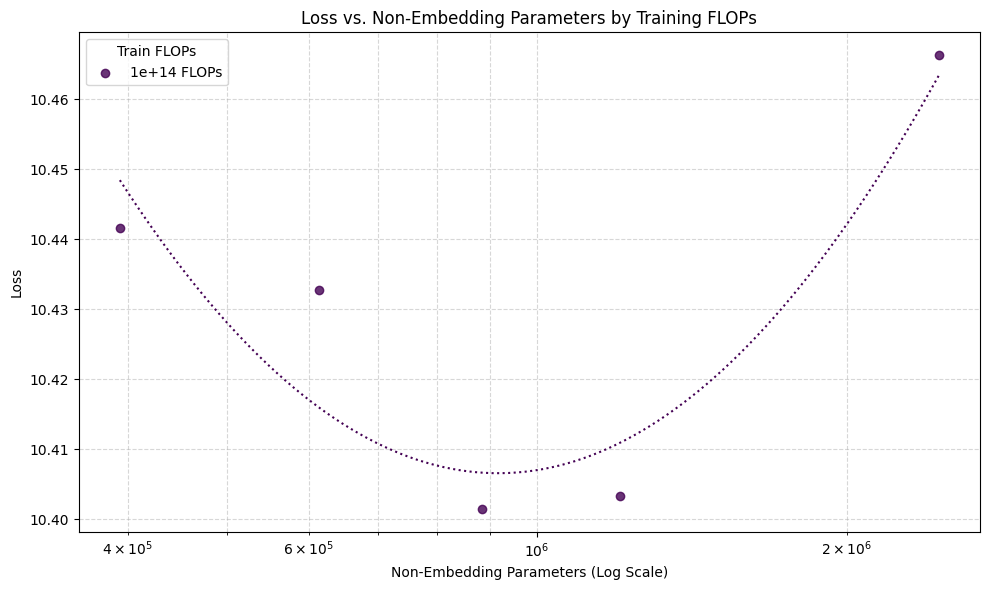

In [14]:
# INITIAL RUNS CENTERED AROUND HOFFMAN/2 GUESS AT 1e14 (factor=5)

C_1 = 1e14
N_1_guess = int(get_chinchilla_n_for_c(C_1) * 0.5) # scaled down chinchilla prediction
# Generate 5 candidates between 1/3 and 3x N_1_guess (i.e. 1/6 and 9/6 Chinchilla N_opt)
candidates = pick_candidates_around_n(N_1_guess, factor=5, n_candidates=5, round_to_int=True)
print_predicted_shapes(ns=candidates, c=C_1)

for n in candidates:
    d, L, h, n_star = get_shape_given_n(n)
    lr = get_chinchilla_lr_for_n(n_star)
    bs = BATCH_SIZE

    # res = {"loss": 0.0, "total_flops_used": 0}

    res = get_loss(
        d_model=d,
        num_layers=L,
        num_heads=h,
        batch_size=bs,
        learning_rate=lr,
        train_flops=C_1,
    )

print_stats_at_c(C_1, sync_api=True)
print_flops_stats()
plot_runs()

Computed shapes:
        c	        n	   n_star	    error	error_pct	        d	        L	      d/L	        h	  pred_lr	embed_ratio	   tokens	    tok/n	tok/n_star
    1e+14	 1.02e+05	 3.93e+05	 2.91e+05	  286.26%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 2.28e+05	 3.93e+05	 1.66e+05	   72.74%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 5.09e+05	 6.14e+05	 1.05e+05	   20.71%	      160	        2	    80.00	        5	 3.21e-04	     0.94	 1.54e+06	     0.14	     2.50
    1e+14	 1.14e+06	 1.20e+06	 6.61e+04	    5.80%	      224	        2	   112.00	        7	 3.00e-04	     0.92	 1.07e+06	     0.07	     0.89
    1e+14	 2.54e+06	 2.46e+06	 8.74e+04	    3.43%	      320	        2	   160.00	       10	 2.80e-04	     0.89	 7.27e+05	     0.03	     0.30
----------------------------------------------------------------------------------------------------
Best for C = 1e+14:
- Non-embedding par

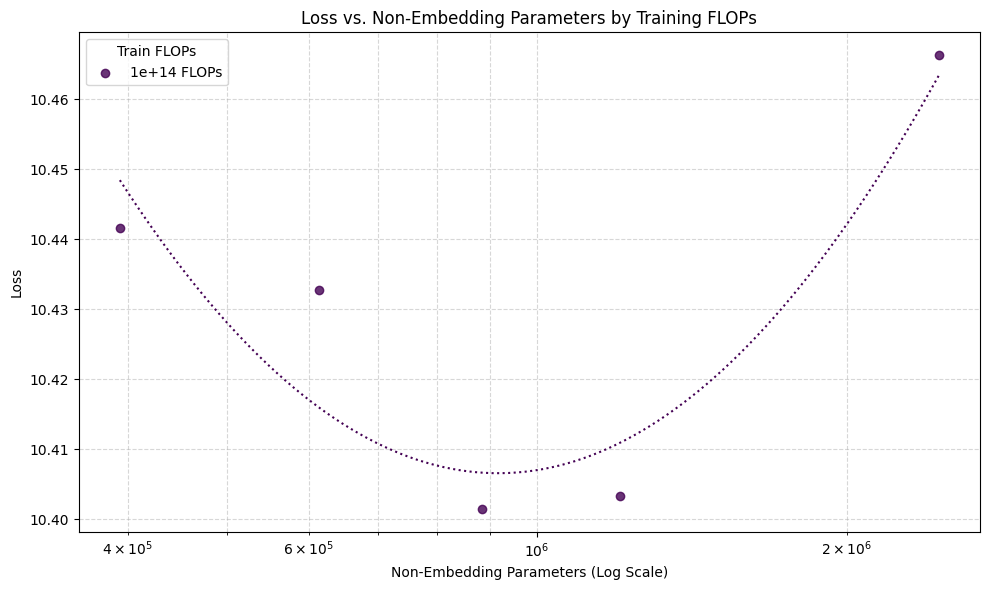

In [ ]:
# INITIAL RUNS CENTERED AROUND HOFFMAN/2 GUESS AT 1e14 (factor=5)

C_1 = 1e14
N_1_guess = int(get_chinchilla_n_for_c(C_1) * 0.5) # scaled down chinchilla prediction
# Generate 5 candidates between 1/3 and 3x N_1_guess (i.e. 1/6 and 9/6 Chinchilla N_opt)
candidates = pick_candidates_around_n(N_1_guess, factor=5, n_candidates=5, round_to_int=True)
print_predicted_shapes(ns=candidates, c=C_1)

for n in candidates:
    d, L, h, n_star = get_shape_given_n(n)
    lr = get_chinchilla_lr_for_n(n_star)
    bs = BATCH_SIZE

    # res = {"loss": 0.0, "total_flops_used": 0}

    res = get_loss(
        d_model=d,
        num_layers=L,
        num_heads=h,
        batch_size=bs,
        learning_rate=lr,
        train_flops=C_1,
    )

print_stats_at_c(C_1, sync_api=True)
print_flops_stats()
plot_runs()

Computed shapes:
        c	        n	   n_star	    error	error_pct	        d	        L	      d/L	        h	  pred_lr	embed_ratio	   tokens	    tok/n	tok/n_star
    1e+14	 2.54e+05	 3.93e+05	 1.39e+05	   54.51%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 3.60e+05	 3.93e+05	 3.33e+04	    9.25%	      128	        2	    64.00	        4	 3.36e-04	     0.95	 1.94e+06	     0.23	     4.94
    1e+14	 5.09e+05	 6.14e+05	 1.05e+05	   20.71%	      160	        2	    80.00	        5	 3.21e-04	     0.94	 1.54e+06	     0.14	     2.50
    1e+14	 7.20e+05	 6.14e+05	 1.05e+05	   14.65%	      160	        2	    80.00	        5	 3.21e-04	     0.94	 1.54e+06	     0.14	     2.50
    1e+14	 1.02e+06	 8.85e+05	 1.33e+05	   13.09%	      192	        2	    96.00	        6	 3.10e-04	     0.93	 1.27e+06	     0.10	     1.43
----------------------------------------------------------------------------------------------------
Best for C = 1e+14:
- Non-embedding par

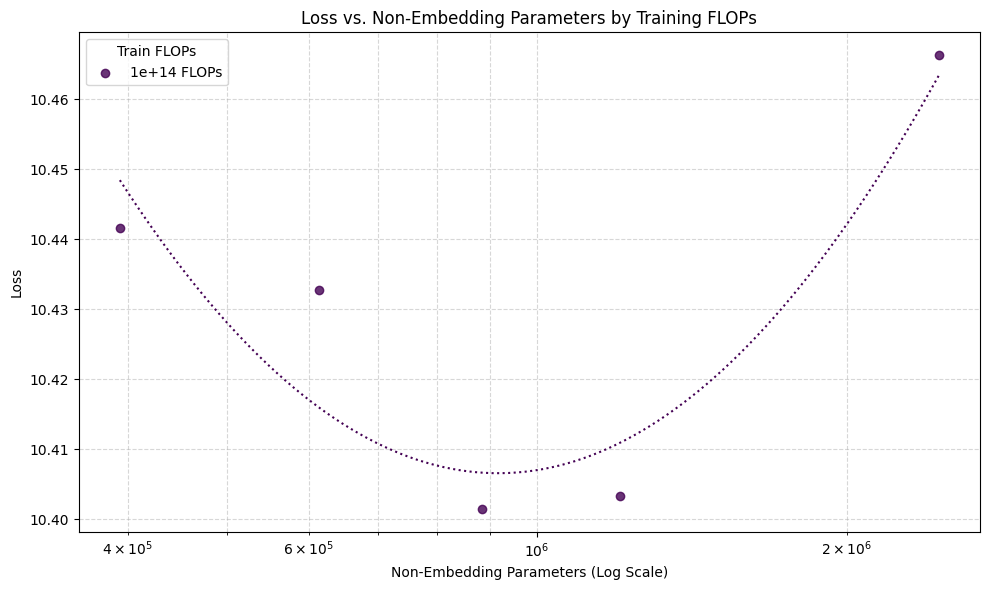

In [15]:
# REFINEMENT RUNS CENTERED AROUND N_1_OPT_SO_FAR (factor=2)

# From best run at C_1 (which was better than quadratic pred. optimal)
N_1_opt_so_far = 1204224

candidates = pick_candidates_around_n(N_1_guess, factor=2, n_candidates=5, round_to_int=True)
print_predicted_shapes(ns=candidates, c=C_1)

for n in candidates:
    d, L, h, n_star = get_shape_given_n(n)
    lr = get_chinchilla_lr_for_n(n_star)
    bs = BATCH_SIZE

    # res = {"loss": 0.0, "total_flops_used": 0}

    res = get_loss(
        d_model=d,
        num_layers=L,
        num_heads=h,
        batch_size=bs,
        learning_rate=lr,
        train_flops=C_1,
    )

print_stats_at_c(C_1, sync_api=True)
print_flops_stats()
plot_runs()

[0.00010214342981599478, 0.00013477906367568096, 0.00017784204072662476, 0.00023466397960677647, 0.000309640977464591, 0.0004085737192639793, 0.000539116254702724, 0.0007113681629064991, 0.0009386559184271061]
Best for C = 1e+14:
- Non-embedding params: 8.85e+05 (884736 params)
- LR: 5.391e-04 (chinchilla: 3.096e-04)
- Loss: 10.00966
- Total params: 1.32e+07 (13172736 params)
- Embedding ratio: 0.93
- Tokens: 1.27e+06 (1265239 tokens)
- Tokens per param (D/N): 0.096
{'d_model': 192, 'num_layers': 2, 'num_heads': 6, 'batch_size': 128, 'learning_rate': 0.0005391163, 'train_flops': 100000000000000.0, 'loss': 10.009664535522461, 'est_n_total': 13172736, 'est_n_non_embedding': 884736, 'est_n_embed': 12288000, 'est_embed_ratio': 0.9328358208955224, 'est_tokens': 1265239.5574212272, 'est_tokens_per_param': 0.09604986825980777}
----------------------------------------------------------------------------------------------------
Quadratic fit for all runs at 1e+14 FLOPs:
0.0393x^2 + -1.1120x + 1

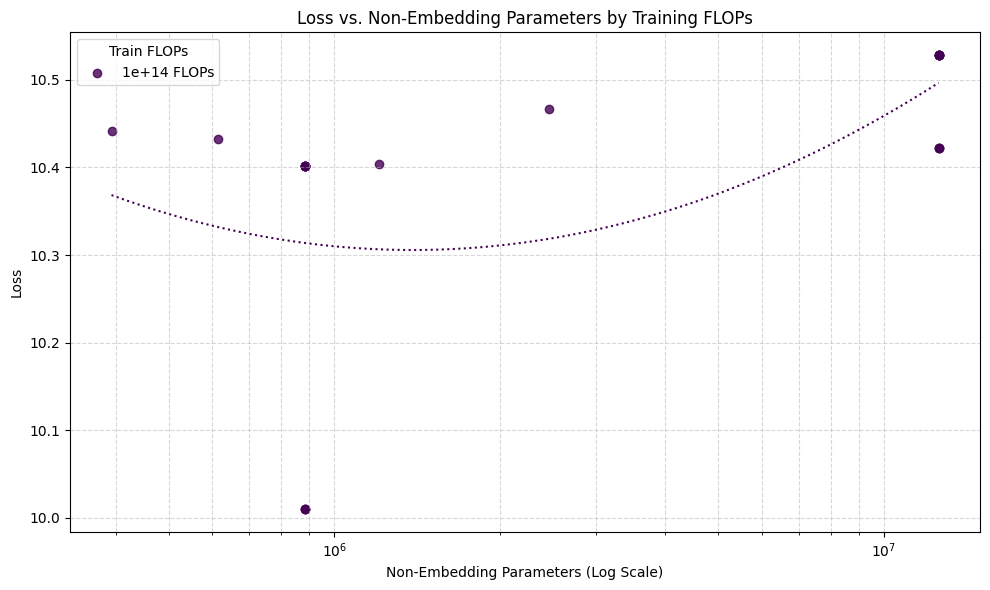

In [19]:
# LEARNING RATE EXPLORATION USING N_1_OPT_SO_FAR

# From new best run at C_1 (better than quadratic pred. optimal)
N_1_opt_so_far = 884736
lr_guess = get_chinchilla_lr_for_n(N_1_opt_so_far)

lr_candidates = pick_candidates_around_n(lr_guess, factor=4, n_candidates=11, round_to_int=False)
lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

print(lr_candidates)

for lr in lr_candidates:
    d, L, h, n_star = get_shape_given_n(N_1_opt_so_far)
    bs = BATCH_SIZE

    res = get_loss(
        d_model=d,
        num_layers=L,
        num_heads=h,
        batch_size=bs,
        learning_rate=lr,
        train_flops=C_1,
    )

print_stats_at_c(C_1, sync_api=True)
print_flops_stats()
plot_runs()

[0.0003593999999999999, 0.00044017330677813705, 0.0005391, 0.0006602599601672057, 0.0008086500000000002]
Best for C = 1e+14:
- Non-embedding params: 8.85e+05 (884736 params)
- LR: 5.391e-04 (chinchilla: 3.096e-04)
- Loss: 10.00966
- Total params: 1.32e+07 (13172736 params)
- Embedding ratio: 0.93
- Tokens: 1.27e+06 (1265239 tokens)
- Tokens per param (D/N): 0.096
{'d_model': 192, 'num_layers': 2, 'num_heads': 6, 'batch_size': 128, 'learning_rate': 0.0005391163, 'train_flops': 100000000000000.0, 'loss': 10.009664535522461, 'est_n_total': 13172736, 'est_n_non_embedding': 884736, 'est_n_embed': 12288000, 'est_embed_ratio': 0.9328358208955224, 'est_tokens': 1265239.5574212272, 'est_tokens_per_param': 0.09604986825980777}
----------------------------------------------------------------------------------------------------
Quadratic fit for all runs at 1e+14 FLOPs:
0.0393x^2 + -1.1120x + 18.1706
Pred. optimal params: 1.39e+06
Pred. loss at optimal params: 10.30576
----------------------------

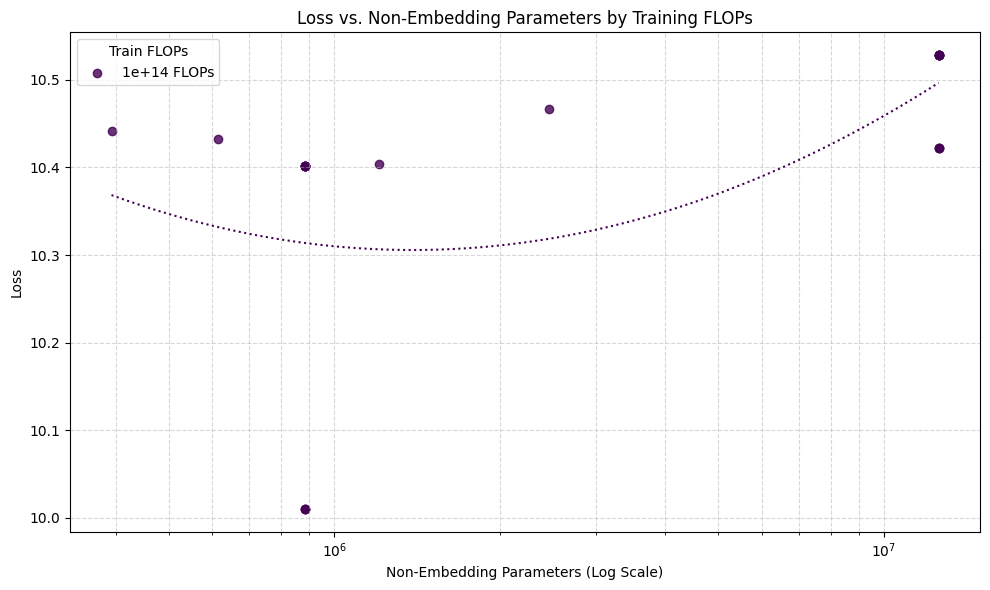

In [ ]:
# LEARNING RATE REFINEMENT EXPLORATION USING LR_OPT_SO_FAR (for N_1_OPT_SO_FAR)

# From new best run at C_1 (better than quadratic pred. optimal)
N_1_opt_so_far = 884736
lr_guess = 5.391e-04

lr_candidates = pick_candidates_around_n(lr_guess, factor=1.5, n_candidates=5, round_to_int=False)
lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

print(lr_candidates)

for lr in lr_candidates:
    d, L, h, n_star = get_shape_given_n(N_1_opt_so_far)
    bs = BATCH_SIZE

    # res = get_loss(
    #     d_model=d,
    #     num_layers=L,
    #     num_heads=h,
    #     batch_size=bs,
    #     learning_rate=lr,
    #     train_flops=C_1,
    # )

print_stats_at_c(C_1, sync_api=True)
print_flops_stats()
plot_runs()